# Biogas Operations Research 📟

## Deadline

12/01/2022 23:59 CET

## Other

*   4 lab points just if you deliver something that works
*   10 points based on the quality of method
*   NO pre-coded libraries, 
*   NO genetic algorithms 
*   NO neural networks
*   groups of max 3 students


## Problem

An association of $n$ farmers wants to open $p$ plants to produce energy from biogas. 
Each plant will be opened at a farm of a member of the association and will be powered with corn chopping purchased from the farm itself or from other neighboring farms.

Each farm $i$ can provide at most $c_i$ tons of corn chopping, with a percentage of dry matter $a_i$. As you may know, dry matter is the key component of corn chopping used for biogas production. In order to maintain the quality of produced energy, each plant must burn a mixture of corn chopping with a percentage of dry matter between $k_{min}$ and $k_{max}$. 

At most one plant can be located in each farm, and every farm can sell its corn chopping to one and only one plant.

Each farm $i$ is located at coordinates $x_i$ and $y_i$, representing respectively its latitude and longitude, and the cost of moving corn chopping from a farm $i$ to a farm $j$ is proportional to the euclidean distance between the two farms (it does not depend on the actual quantity moved, since the trucks used for this transportations are sufficiently big). 

Under such conditions, every plant produces $Q$ kWh of energy per ton of corn chopping burned. The energy produced by each plant will be fed into the national electricity system, at a unitary price of $b$ (€/kWh). Moreover, due to state regulations, each plant must not produce more than $M$ kWh of energy.

You must locate $p$ plants among the available farms and assign the farms that will supply each plant, with the goal of maximizing the total revenues of the association.

## Solution

### Utility 🫧

In [1]:
!pip install --upgrade cffi==1.15.0
import importlib
import cffi
importlib.reload(cffi)
!pip install mip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 446 kB 5.1 MB/s 
  Attempting uninstall: cffi
    Found existing installation: cffi 1.15.1
    Uninstalling cffi-1.15.1:
      Successfully uninstalled cffi-1.15.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 5.3 MB/s 


Import libraries

In [1]:
import time
start = time.time()

In [2]:
import json
import math
import matplotlib.pyplot as plt
import mip
import networkx as nx
import numpy as np

Download given instances:

In [3]:
instNum = 4

# Clean files if present
!rm instance_{instNum}.json
!rm instance_{instNum}.txt

# Download instance (both instance and solution) directly from Github
!wget https://raw.githubusercontent.com/Daddeee/FOR_Labs_22-23/master/big-project/instances/instance_{instNum}.json
!wget https://raw.githubusercontent.com/Daddeee/FOR_Labs_22-23/master/big-project/results/instance_{instNum}.txt

rm: cannot remove 'instance_4.json': No such file or directory
rm: cannot remove 'instance_4.txt': No such file or directory
--2022-12-23 17:47:43--  https://raw.githubusercontent.com/Daddeee/FOR_Labs_22-23/master/big-project/instances/instance_4.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4740 (4.6K) [text/plain]
Saving to: ‘instance_4.json’

instance_4.json     100%[===================>]   4.63K  --.-KB/s    in 0s      

2022-12-23 17:47:44 (44.8 MB/s) - ‘instance_4.json’ saved [4740/4740]

--2022-12-23 17:47:44--  https://raw.githubusercontent.com/Daddeee/FOR_Labs_22-23/master/big-project/results/instance_4.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to r

Read and load given instances and results:

In [4]:
# Reads a .json instance and returns it in a dictionary
def load_instance(filename):
  with open(filename, 'r') as f:
    data = json.load(f)
  return data

# Reads a .txt result and returns it
def load_result(filename):
  with open(filename, 'r') as f:
      result = f.read()
  return float(result)

In [5]:
instance = load_instance("instance_{}.json".format(instNum))
if instNum < 5:
  given_result = load_result("instance_{}.txt".format(instNum))

### Model

In [6]:
model = mip.Model(sense="MAXIMIZE", solver_name="CBC")

### Sets
*   $I$ = set of farms

In [7]:
I = range(instance["n"])

### Parameters
*   $n$ = number of farms   
*   $p$ = number of plants to locate
*   $b$ = revenue per unit of energy (€/kWh)
*   $M$ = max energy production (kWh)
*   $Q$ = energy produced by a ton of corn chopping (kWh/t)
*   $k_{min} (k_{max})$ = min (max) percentage of dry matter for fermentation
*   $a_i$ = percentage of dry matter in chopping from farm $i \in I$
*   $c_i$ = tons of corn chopping available for each $i \in I$ (t)
*   $x_i, y_i$ = coordinates of farm $i \in I$

In [8]:
M = instance["M"]  # M is max energy production
Q = instance["Q"]  # Energy produced for ton (kWh / ton)
a = instance["a"]  # % of dry matter
b = instance["b"]  # Revenue (Euros / kWh)
c = instance["c"]  # Availability (ton)
kmax = instance["kmax"]  # Max % of dry matter
kmin = instance["kmin"]  # Min % of dry matter
n = instance["n"]  # Number of farms
p = instance["p"]  # Number of plants
points = instance["points"]  # Coordinates of farms (x, y)

In [9]:
print("Max energy production:", M)
print("")

Max energy production: 2099000



### Variables

* We need variables to know in which farms the plants will be located: $u_i$ is 1 if in the farm $i$ will be located a plant, 0 otherwise

* We need variables to know how to move corn chopping between farms: $v_{ij}$ is 1 if material is moved from farm $i$ to farm $j$

* We need variables to know how much corn chopping we move between farms: $w_{ij}$ is the amount of corn chopping moved from farm $i$ to farm $j$.

In [10]:
u = [model.add_var(name="is_plant", var_type=mip.BINARY) for i in I]  # Represents if plant exists in farm i
v = [[model.add_var(name="selling_to", var_type=mip.BINARY) for i in I] for j in I]  # Represents if farm i sells to plant j
w = [[model.add_var(name="material_amount", var_type=mip.CONTINUOUS, lb=0.0) for i in I] for j in I]  # Represents quantity farm i sells to plant j

### Constraints

We must have a total of $p$ plants located: $\sum_{i \in I} u_i = p$

In [11]:
model.add_constr(mip.xsum(u[i] for i in range(len(u))) == p)

When the corn chopping is moved from a farm $i$ to another farm $j$, the farm $j$ must be a plant: $v_{ij} \le u_j$ that must hold for each $(i, j)\in I \times I$

In [12]:
for i in I:
  for j in I:
    model.add_constr(v[i][j] <= u[j])

When a corn chopping is moved from a farm $i$, it must be sent to one and only one farm/plant: $\sum_{j \in I} (v_{ij}) \le 1$ that must hold for each farm $i\in I$

In [13]:
for i in I:
  model.add_constr(mip.xsum(v[i][j] for j in I) <= 1)

The amount of corn chopping that will be moved from a farm $i$ to a farm/plant $j$ can be greater than zero if and only if it is $v_{ij} = 1$. If it holds, $w_{ij}$ must not be greater than the availability of corn chopping of the farm $i$: $0 \leq w_{ij} \le v_{ij}\cdot c_i$ that must hold for each $(i, j)\in I \times I$

In [14]:
for i in I:
  for j in I:
    model.add_constr(w[i][j] <= c[i] * v[i][j])

What is burnt by a plant, must have a dry matter percentage between specific values. For each farm $i$, we consider the backward star and we sum all the corn chopping that is coming to the farm $i$. We get the average and we impose that it is greater than a minimum. It is the same for the maximum. It holds for each farm because if the farm $i$ is not a plant, it will be $0 \le 0$, because we know from the previous constraints that $w_{ji}$ is greater than $0$ if the arc $v_{ji}$ is active, which in turn is $1$ if $x_i$ is $1$. So, the constraints are:
    
*  $\sum_{j\in I}(w_{ji}\cdot a_j)\geq k_{min}\cdot (\sum_{j\in I}(w_{ji}))$     that must hold for each farm $i\in I$
    
*  $\sum_{j\in I}(w_{ji}\cdot a_j)\leq k_{max}\cdot (\sum_{j\in I}(w_{ji}))$     that must hold for each farm $i\in I$

In [15]:
for i in I:
  model.add_constr(mip.xsum(w[j][i] * a[j] for j in I) >= mip.xsum(w[j][i] * kmin for j in I))
  model.add_constr(mip.xsum(w[j][i] * a[j] for j in I) <= mip.xsum(w[j][i] * kmax for j in I))

Due to state regulations, we have a limit on the energy produced by each plant. This constraint is introduced for each farm $i$. So, it is: $(\sum_{j\in I} (w_{ji}))\ \cdot\ Q \le M$

In [16]:
for i in I:
  model.add_constr(mip.xsum(w[j][i] for j in I) * Q <= M)

### Objective Function & Optimization 🎯

In [17]:
model.objective = mip.maximize(mip.xsum(w[i][j] * Q * b for i in I for j in I) - (mip.xsum(math.sqrt(math.pow(points[i][0] - points[j][0], 2) + math.pow(points[i][1] - points[j][1], 2)) * v[i][j] for i in I for j in I)))

In [18]:
model.optimize(max_seconds=600) # Max 10 mins to optimize everything
result = model.objective_value

### Visualization ✨

In [19]:
selected = [i for i in I if u[i].x == 1]
print("selected items: {}".format(selected))

selected items: [2, 5, 7, 8, 11, 16, 19, 26, 29, 31, 34, 35, 41, 43, 44, 47]


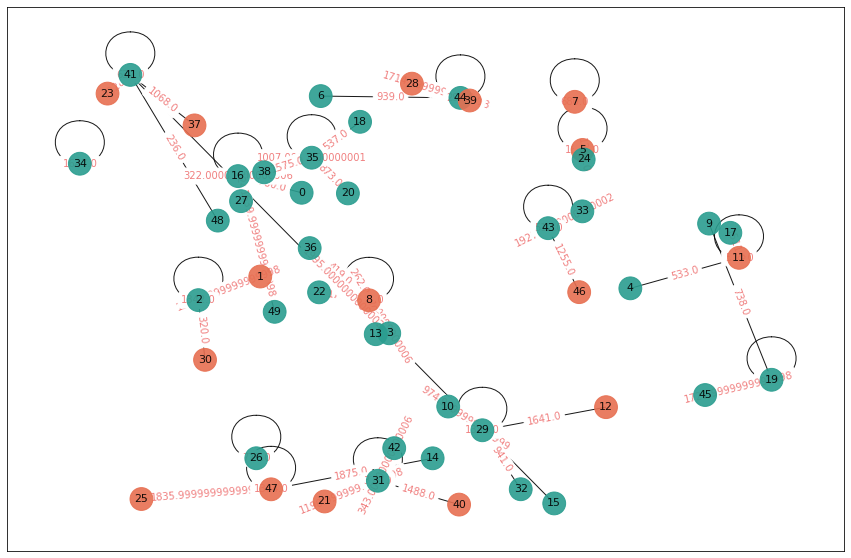

In [20]:
G = nx.Graph()

for i in I:
  G.add_node(i, pos=points[i])
  for j in I:
    if v[i][j].x == 1:
      G.add_edge(i,j, label=w[i][j].x)

pos=nx.get_node_attributes(G,'pos')

color_map = ['#e76f51' if u[i].x == 1 else '#2a9d8f' for i in I]

plt.figure(1, figsize=(15,10))
nx.draw_networkx(G, font_size=11, pos=pos, node_color=color_map, node_size=520, alpha=0.90)
nx.draw_networkx_edge_labels(G,pos,edge_labels=nx.get_edge_attributes(G,'label'), font_color='#f08080')
plt.show()


### Evaluation

In [21]:
gap = 100 * (result - given_result) / given_result

print("REVENUE: {}".format(result))
print("EXPECTED: {}".format(given_result))
print("[!] GAP: {}".format(gap))

REVENUE: 9414565.531051388
EXPECTED: 9414476.549923249
[!] GAP: 0.0009451521565492322


In [ ]:
end = time.time()
print("[!] Execution Time:", end - start)

[!] Execution Time: 4.2080206871032715
